In [1]:
!nvidia-smi


Wed Sep 23 21:29:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 55%   84C    P2   247W / 250W |  10883MiB / 11175MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   37C    P8     8W / 250W |  10889MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

Using TensorFlow backend.


In [2]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import keras
from keras.models import *
from keras.layers import *

from keras import layers
import keras.backend as K

def one_side_pad(x):
    x = ZeroPadding2D((1, 1))(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):

    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, dilation_rate=(2, 2), padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=256,  input_width=256, classes=1000):

    #assert input_height % 32 == 0
    #assert input_width % 32 == 0
 
    img_input = Input(shape=(input_height, input_width, 3))
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7),strides=(2, 2), name='conv1')(x)
    
    #x = (concatenate([x1,x_re]))
    
    f1 = x

    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3),strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    # f6 = x

    return img_input, [f1, f2, f3, f4, f5]







def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608,encoder_level=4):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels
    o = f5

    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(512, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2)))(o)
    o = (concatenate([o, f4]))
    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(256, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2)))(o)
    o = (concatenate([o, f3], axis=-1))
    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(128, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)
    
    
    o = (UpSampling2D((2, 2)))(o)
    o = (concatenate([o, f2], axis=-1))
    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(128, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)

    o = (UpSampling2D((2, 2)))(o)

    if l1_skip_conn:
        o = (concatenate([o, f1], axis=-1))

    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(64, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)
    
    o = (UpSampling2D((2, 2)))(o)
    o = (ZeroPadding2D((1, 1)))(o)
    o = (Conv2D(64, (3, 3), padding='valid'))(o)
    o = (BatchNormalization())(o)

    o = Conv2D(n_classes, (3, 3), padding='same')(o)

  
    o = Activation('softmax')(o)
    model = Model(img_input, o)

    return model





def resnet50_unet(n_classes, input_height=576, input_width=768,
                    encoder_level=3):
    
    model = _unet(n_classes, get_resnet50_encoder,
                  input_height=input_height, input_width=input_width)
    model.model_name = "resnet50_unet"
    model.save('path_to_my_model.h5')
    return model
model = resnet50_unet(3, input_height=None, input_width=None, encoder_level=4)


Using TensorFlow backend.








Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead








In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [4]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)
path_output ='/home/sami/Downloads/Canola Dataset/labeled/Final 98/Results/Unet-resent'

model.load_weights('unet_resnet_50_simple.h5')

anot_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Field_Image_all/*.JPG')
anot_list = sorted_nicely(anot_list)
y_train = np.asarray(anot_list)
for fname in y_train:
    X_train = np.array([image.img_to_array(image.load_img(fname,target_size=(1056,1600)))])
    pre= model.predict(X_train)
    pr=pre.reshape((pre.shape[0],pre.shape[1],  pre.shape[2], 3)).argmax(axis=3)
    pred2 =pre.copy()
    for c in range(3):
        pred2[0,:, :, c] = (pr[0] == c).astype(int)
    pred2[:,:,:,2]=0 
    
    cv2.imwrite(os.path.splitext(os.path.join(path_output , os.path.basename(fname)))[0]+'.png',cv2.cvtColor(pred2[0]*255.0, cv2.COLOR_RGB2BGR))


In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np
path='/home/sami/Downloads/Canola Dataset/labeled/Final 98/heatmaps/PICT_20190531_102845.png'
y_train =np.array([image.img_to_array(image.load_img(path,grayscale=True))])

In [4]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np

def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)
    
orig_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_xtrain/split/split/*.png')
orig_list = sorted_nicely(orig_list)
anot_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytrain/ysplit/*.png')
#anot_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytrain/ysplitnew/*.png')


anot_list = sorted_nicely(anot_list)
orig_train, orig_test, anot_train, anot_test = train_test_split(orig_list,anot_list,test_size = 0.1)

x_train = np.asarray(orig_train)
y_train = np.asarray(anot_train)
x_val   = np.asarray(orig_test)
y_val   = np.asarray(anot_test)

Y_train = np.array([image.img_to_array(image.load_img(fname)) for fname in y_train])
X_train = np.array([image.img_to_array(image.load_img(fname)) for fname in x_train]) #
Y_val = np.array([image.img_to_array(image.load_img(fname)) for fname in y_val])
X_val = np.array([image.img_to_array(image.load_img(fname)) for fname in x_val])
"""
x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
Y_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])

X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])"""

'\nx_train = np.asarray(orig_list)\ny_train = np.asarray(anot_list)\nY_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])\n\nX_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])'

In [ ]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np

def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)


#orig_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_xtest/*.jpg')
#orig_list = sorted_nicely(orig_list)
anot_list = glob.glob('/home/sami/Downloads/ijrr_sugarbeets_2016_annotations/Data/Xtest/*.png')
anot_list = sorted_nicely(anot_list)
#orig_train, orig_test, anot_train, anot_test = train_test_split(orig_list,anot_list,test_size = 0.1)

#x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
#x_val   = np.asarray(orig_test)
#y_val   = np.asarray(anot_test)
#,target_size = (576,768)
#Y_train = np.array([image.img_to_array(image.load_img(fname)) for fname in y_train])
#X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,800))) for fname in x_train])
#Y_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_val])
#X_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_val])
"""
x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
Y_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])

X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])"""

In [44]:
Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2]))

In [45]:
Y_train.max()

2.0

In [39]:
Y_train[1542].max()

1.0

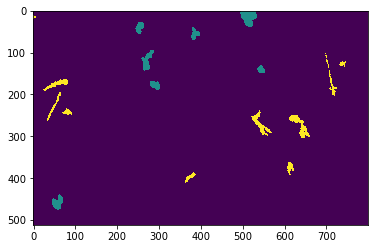

In [46]:
plt.imshow(Y_train[1543])

In [4]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split


def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)


orig_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_xtest/*.jpg')
orig_list = sorted_nicely(orig_list)
anot_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytest/*.png')
anot_list = sorted_nicely(anot_list)
#orig_train, orig_test, anot_train, anot_test = train_test_split(orig_list,anot_list,test_size = 0.1)

x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
#x_val   = np.asarray(orig_test)
#y_val   = np.asarray(anot_test)
#,target_size = (576,768)
Y_train = np.array([image.img_to_array(image.load_img(fname)) for fname in y_train])
X_train = np.array([image.img_to_array(image.load_img(fname)) for fname in x_train])
#Y_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_val])
#X_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_val])
"""
x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
Y_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])

X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])"""

'\nx_train = np.asarray(orig_list)\ny_train = np.asarray(anot_list)\nY_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])\n\nX_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])'

In [ ]:
Y_train.shape

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(Y_train[5])

In [ ]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split


def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)


orig_list = glob.glob('/home/sami/Downloads/Canola All/UofR Shared Folder/Borstmayer Sids East of Road 2nd pass/*.JPG')
orig_list = sorted_nicely(orig_list)
#anot_list = glob.glob('/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytest/*.png')
#anot_list = sorted_nicely(anot_list)
#orig_train, orig_test, anot_train, anot_test = train_test_split(orig_list,anot_list,test_size = 0.1)

x_train = np.asarray(orig_list)
#y_train = np.asarray(anot_list)
#x_val   = np.asarray(orig_test)
#y_val   = np.asarray(anot_test)

#Y_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])
X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (1056,1600))) for fname in x_train])
#Y_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_val])
#X_val = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_val])
"""
x_train = np.asarray(orig_list)
y_train = np.asarray(anot_list)
Y_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in y_train])

X_train = np.array([image.img_to_array(image.load_img(fname,target_size = (576,768))) for fname in x_train])"""

In [9]:
X_train.shape

(5976, 512, 800, 3)

In [4]:
copied = Y_train.copy()
a=np.logical_xor(Y_train[:,:,:,1],Y_train[:,:,:,2])
b= np.subtract(a,Y_train[:,:,:,1])

copied[:,:,:,0] = np.logical_not(a)
copied[:,:,:,1] = Y_train[:,:,:,1]
copied[:,:,:,2] = b

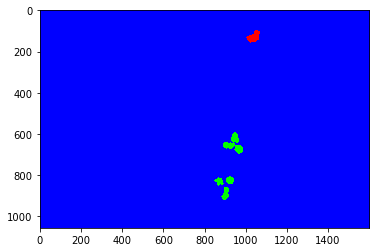

In [7]:
from matplotlib import pyplot as plt
plt.imshow(copied[125])

In [7]:
copied.shape

(5976, 512, 800, 3)

In [8]:
import cv2
path = '/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytrain/ysplitnew/'
for i in range(1,copied.shape[0]+1):
    name=str(i)+'.png'
    
    
    cv2.imwrite(os.path.join(path , name), one_chanel[i-1])

NameError: name 'one_chanel' is not defined

In [9]:
val = Y_val.copy()
a=np.logical_xor(Y_val[:,:,:,1],Y_val[:,:,:,2])
b= np.subtract(a,Y_val[:,:,:,1])

val[:,:,:,0] = np.logical_not(a)
val[:,:,:,1] = Y_val[:,:,:,1]
val[:,:,:,2] = b

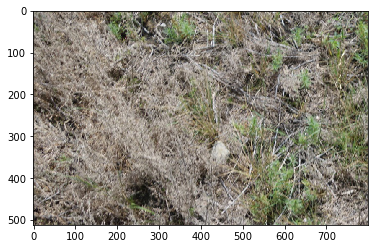

In [10]:
from matplotlib import pyplot as plt
plt.imshow(X_train[145]/255)

In [10]:
del Y_train,a,b

In [ ]:
"""#full = np.array([image.img_to_array(image.load_img(fname)) for fname in anot_list])
copied = full.copy()
a=np.logical_xor(full[:,:,:,1],full[:,:,:,2])
b= np.subtract(a,full[:,:,:,1])

copied[:,:,:,0] = np.logical_not(a)
copied[:,:,:,1] = full[:,:,:,1]
copied[:,:,:,2] = b
"""

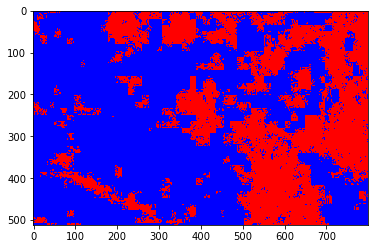

In [11]:
from matplotlib import pyplot as plt
plt.imshow(copied[145])

In [8]:
sumof = np.sum(copied,axis=3)
sumof.max()

1.0

In [18]:
one_chanel.max()

2.0

In [ ]:
sumof = np.sum(val,axis=3)
sumof.max()

In [19]:
sumofa = np.sum(copied)


In [41]:
wb = assd-copied[:,:,:,0]

In [34]:
w = assd-copied[:,:,:,2]-copied[:,:,:,0]

In [35]:
w = np.sum(w)
print(w)

159035230.0


In [44]:
w=np.logical_and(wb,copied[:,:,:,2])

In [45]:
w1 = np.sum(w)
print(w1)

1909733755


In [37]:
wcs = np.sum(wc)
print(wcs)

538026300.0


In [40]:
wcs-w1

378989078.0

In [25]:
assd.max()

1.0

In [22]:
sumofw = np.sum(copied[:,:,:,0])
sumofb = np.sum(copied[:,:,:,2])
sumofc = np.sum(copied[:,:,:,1])


In [29]:
print(sumofc)
print(sumofb)
print(sumofw)

159035230.0
1909820700.0
378995360.0


In [27]:
print(sumofa)

2442989600.0


In [17]:
sun=np.sum(assd)
print(sun)

2447769600.0


In [ ]:
sumofb = np.sum(copied[:,:,:,2])
print(sumof)

In [28]:
copied.shape

(5976, 512, 800, 3)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(Y_train[234,:,:])

In [10]:
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


def some_function(arr):
    arr = to_categorical(arr[:,:,0], num_classes=3)
    return arr

data_gen_args = dict(zoom_range=0.2,
                     rotation_range=40,
                     vertical_flip=True,
                     horizontal_flip=True)
image_datagen = ImageDataGenerator(zoom_range=0.2,
                                  rotation_range=40,
                                  vertical_flip=True,
                                  validation_split=0.1,
                                  horizontal_flip=True)
mask_datagen = ImageDataGenerator(zoom_range=0.2,
                                  rotation_range=40,
                                  vertical_flip=True,
                                  horizontal_flip=True,
                                  validation_split=0.1,
                                 preprocessing_function=some_function)


seed=1
image_generator = image_datagen.flow_from_directory(
    '/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_xtrain/split',
    target_size=(512, 800),
    batch_size=2,
    class_mode=None,
    seed=seed)
mask_generator = mask_datagen.flow_from_directory(
    '/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytrain/y',
    target_size=(512, 800),
    batch_size=2,
    class_mode=None,
    #color_mode='grayscale',
    seed=seed)
# combine generators into one which yields image and masks

train_generator = zip(image_generator, mask_generator)

Found 5976 images belonging to 1 classes.
Found 5976 images belonging to 1 classes.


In [11]:
from keras_preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


def some_function(arr):
    arr = to_categorical(arr[:,:,0], num_classes=3)
    return arr

data_gen_args = dict(zoom_range=0.2,
                     rotation_range=40,
                     vertical_flip=True,
                     horizontal_flip=True)
image_datagen = ImageDataGenerator()
mask_datagen = ImageDataGenerator(preprocessing_function=some_function)


seed=1
vimage_generator = image_datagen.flow_from_directory(
    '/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_xtrain/val',
    target_size=(512, 800),
    batch_size=2,
    class_mode=None,
    seed=seed)
vmask_generator = mask_datagen.flow_from_directory(
    '/home/sami/Downloads/Canola Dataset/labeled/Final 98/Aug_ytrain/yval',
    target_size=(512, 800),
    batch_size=2,
    class_mode=None,
    #color_mode='grayscale',
    seed=seed)
# combine generators into one which yields image and masks

val_generator = zip(vimage_generator, vmask_generator)

Found 664 images belonging to 1 classes.
Found 664 images belonging to 1 classes.


In [47]:
for (img, mask) in train_generator:
    img=img
    mask=mask
    break

(512, 800, 3)
(512, 800, 3)
(512, 800, 3)
(512, 800, 3)
(512, 800, 3)


In [52]:
import numpy as np
asd=np.sum(mask,axis=3)
asd.max()

1.0

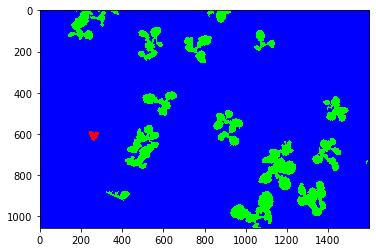

In [10]:
from matplotlib import pyplot as plt
plt.imshow(copied[7,:,:,:])

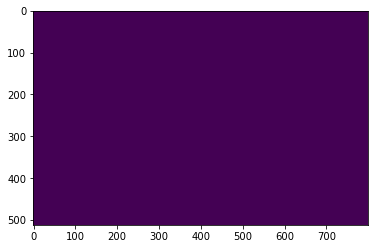

In [40]:
plt.imshow(mask[3,:,:,2]-mask[3,:,:,1])

In [43]:
(mask[3,:,:,2]-mask[3,:,:,0]).max()

0.0

In [19]:
from keras.utils import to_categorical
cata = to_categorical(mask, num_classes=3)

NameError: name 'mask' is not defined

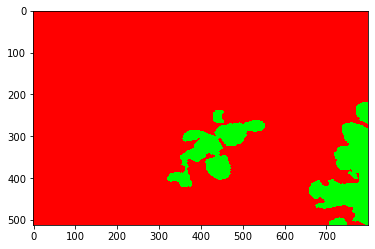

In [32]:
from matplotlib import pyplot as plt
plt.imshow(cata[2,:,:,:]/1)

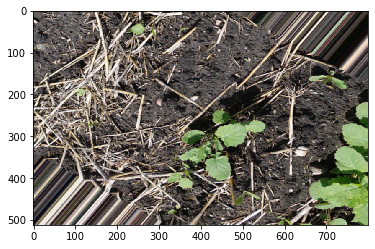

In [31]:
from matplotlib import pyplot as plt
plt.imshow(img[2,:,:,:]/255)

In [18]:
import numpy as np
np.sum(cata[3],axis=2).max()

1.0

In [28]:
a= mask_generator.next()

In [29]:
a[0].shape

(512, 800, 1)

In [33]:
a[0,:,:,0].max()

2.0

In [40]:
cata.max()

1.0

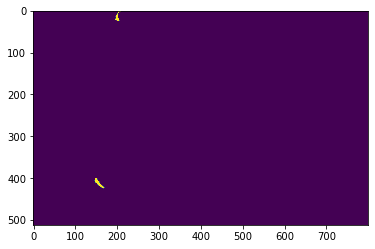

In [32]:
from matplotlib import pyplot as plt
plt.imshow(a[0,:,:,0])

In [21]:
a[0].max()

2.0

In [8]:
import tensorflow as tf
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

In [9]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001, beta_1=0.5)
model.compile(loss=dice_loss, optimizer=opt, metrics=["accuracy"])

In [5]:
model.load_weights('unet_resnet_50_simple.h5')

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('unet_resnet_50_simple.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
history = model.fit(X_train,copied, batch_size=2, epochs=200,callbacks=callbacks,validation_data=(X_val,val),initial_epoch=53)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Train on 5976 samples, validate on 664 samples
Epoch 54/200
 346/5976 [>.............................] - ETA: 4:28:55 - loss: 0.0128 - acc: 0.9808

In [1]:
history

history


In [ ]:
import pandas as pd

# assuming you stored your model.fit results in a 'history' variable:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_unet_simple_resnet.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history_unet_simple_resnet.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    

In [2]:
from matplotlib import pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    #EarlyStopping(patience=20, verbose=1),
    ModelCheckpoint('unet_resnet50_modifeid.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
model.load_weights('unet_resnet50_modifeid.h5')

In [ ]:
history = model.fit(X_train, copied, batch_size=3, epochs=300,callbacks=callbacks,validation_data=(X_val,val),initial_epoch=33)

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_unet_modified.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history_unet_modified.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
model.load_weights('unet_resnet50_with_dice_modified_new.h5')


In [ ]:
X_train.shape

In [ ]:
del X_val,val,X_train,copied

In [ ]:
del X_train

In [ ]:
X_train.shape

In [12]:
model.load_weights('0.89miou unet.h5')

In [ ]:
pred1=model.predict(X_train[0:1])
pred1[0].shape

In [ ]:
pred1=model.predict(X_train[0:1])

In [6]:
pred=[]
for i in range(X_train.shape[0]):
    pred1=model.predict(X_train[i:i+1])
    pred.append(pred1[0])

In [7]:
pred=np.asarray(pred)

In [ ]:
import os
os.path.basename(anot_list[0])

In [ ]:
plt.imshow(pred[8])

In [8]:
pr=pred.reshape((pred.shape[0],pred.shape[1],  pred.shape[2], 3)).argmax(axis=3)

In [9]:
pr.max()

2

In [10]:
pred2=pred.copy()
for i in range(pred.shape[0]):
    for c in range(3):
        pred2[i,:, :, c] = (pr[i] == c).astype(int)

In [11]:
pred2[:,:,:,2] = 0

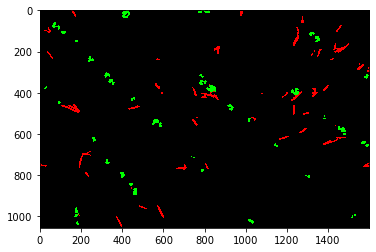

In [13]:
from matplotlib import pyplot as plt
plt.imshow(pred2[128])

In [14]:
import cv2
import os
path = '/home/sami/image-keras-segmentation/Unet_simple_withresnet'
cv2.imwrite(os.path.splitext(os.path.join(path , os.path.basename(orig_list[128])))[0]+'.png',cv2.cvtColor(pred2[128]*255.0, cv2.COLOR_RGB2BGR))

True

In [ ]:
len(orig_list)

In [ ]:
pred2=pred2*255.0
pred2.max()

In [ ]:
os.path.splitext(os.path.join(path2 , os.path.basename(orig_list[i])))[0]

In [24]:
os.path.basename(orig_list[0])

'0.jpg'

In [26]:


import cv2
import os
path1 ='/home/sami/Downloads/Canola Dataset/labeled/Final 98/x_visual/'
path2 ='/home/sami/Downloads/Canola Dataset/labeled/Final 98/yprd_unet_modified/'
for i in range(0,pred2.shape[0]):
    #cv2.imwrite(os.path.join(path1 , os.path.basename(orig_list[i])),cv2.cvtColor(X_train[i], cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.splitext(os.path.join(path2 , os.path.basename(orig_list[i])))[0]+'.png',cv2.cvtColor(pred2[i]*255.0, cv2.COLOR_RGB2BGR))
   
    

In [ ]:
import cv2
import os
path1 = '/home/sami/Downloads/Canola Dataset/labeled/Final 98/ytest_pred/'
path2 = '/home/sami/Downloads/Canola Dataset/labeled/Final 98/ytest_visual/'
a=copied.copy()
a[:,:,:,0] = 0
a[:,:,:,2] = copied[:,:,:,0].copy()
b=pred.copy()
b[:,:,:,0] = 0
b[:,:,:,2] = pred[:,:,:,0].copy()


for i in range(0,copied.shape[0]):
    filename= str(i)+'.jpg'
    
    cv2.imwrite(os.path.join(path1 , filename),b[i]*255.0)
    
    cv2.imwrite(os.path.join(path2 , filename),a[i]*255.0)
    

In [ ]:
X_train.max()

In [ ]:
 n

In [ ]:
#pred = np.asarray(pred)
import os
print(os.path.splitext(os.path.basename(x_train[0]))[0])

In [ ]:
filename= str(os.path.splitext(os.path.basename(x_train[0]))[0])+'.png'
print(filename)

In [ ]:
plt.imshow(copied[22])

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(pred[22])

In [ ]:
global model

In [13]:
def rescale_frame(frame, percent=75):
    import cv2
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


#def evaluation(y,stage,model_name,pred):#,pred2
  
pred1=pred
gt = copied
pr=pred1.reshape((pred1.shape[0],pred1.shape[1],  pred1.shape[2], 3)).argmax(axis=3)
tp = np.zeros(3)
fp = np.zeros(3)
fn = np.zeros(3)

n_pixels = np.zeros(3)
gt = gt.argmax(-1)
pr = pr.flatten()
gt = gt.flatten()
for cl_i in range(3):
    tp[ cl_i ] += np.sum( (pr == cl_i) * (gt == cl_i) )
    fp[ cl_i ] += np.sum( (pr == cl_i) * ((gt != cl_i)) )
    fn[ cl_i ] += np.sum( (pr != cl_i) * ((gt == cl_i)) )
    n_pixels[ cl_i ] += np.sum( gt == cl_i  )

cl_wise_score = tp / ( tp + fp + fn + 0.000000000001 )
n_pixels_norm = n_pixels /  np.sum(n_pixels)
frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
mean_IU = np.mean(cl_wise_score)
dice = 2*tp/(2*tp+fp+fn)
print(dice,'Dice class wise')
print(np.mean(dice),'mean Dice')
print("frequency_weighted_IU",frequency_weighted_IU , "mean_IU",mean_IU , "class_wise_IU",cl_wise_score)
"""
    import cv2
    if stage ==4:
        file =865
        ass  = pred2
    if stage==1:
        file =1494
    if stage ==2:
        file =3247
    if stage == 3:
        file =1682
    if stage!=4:    
        ass = pred1[file:file+1]
    filename=str(stage)
    pr=ass.reshape((ass.shape[0],384,  512, 3)).argmax(axis=3)
    for i in range(ass.shape[0]):
        ass[i,:,:,0]=0
        ass[i,:,:,1]=np.where(pr==1,1,0);
        ass[i,:,:,2]=1-np.where(pr==2,1,0)-np.where(pr==1,1,0)
    model=str(model_name)
    #frame1 = rescale_frame(x[file,:,:,0:3]*255.0, percent=150)
    #cv2.imwrite('X'+filename+'th.jpg',frame1)
    #frame2 = rescale_frame(x[file,:,:,3]*255.0, percent=150)
    #cv2.imwrite('X'+filename+'thnir.jpg', frame2)
    #frame3 = rescale_frame(y[file]*255.0, percent=150)
    #frame3[:,:,2]=frame3[:,:,0]
    #frame3[:,:,0]=0
    #cv2.imwrite('X'+filename+'thGround_truth.jpg',frame3)
    frame4 = rescale_frame(ass[0]*255.0, percent=150)
    cv2.imwrite('X'+filename+'th'+model+'.jpg', frame4)
     
    return"""

[0.9000449  0.92587913 0.99066727] Dice class wise
0.938863767996033 mean Dice
frequency_weighted_IU 0.9669865620747503 mean_IU 0.8872503381205639 class_wise_IU [0.81825603 0.86198785 0.98150714]


"\n    import cv2\n    if stage ==4:\n        file =865\n        ass  = pred2\n    if stage==1:\n        file =1494\n    if stage ==2:\n        file =3247\n    if stage == 3:\n        file =1682\n    if stage!=4:    \n        ass = pred1[file:file+1]\n    filename=str(stage)\n    pr=ass.reshape((ass.shape[0],384,  512, 3)).argmax(axis=3)\n    for i in range(ass.shape[0]):\n        ass[i,:,:,0]=0\n        ass[i,:,:,1]=np.where(pr==1,1,0);\n        ass[i,:,:,2]=1-np.where(pr==2,1,0)-np.where(pr==1,1,0)\n    model=str(model_name)\n    #frame1 = rescale_frame(x[file,:,:,0:3]*255.0, percent=150)\n    #cv2.imwrite('X'+filename+'th.jpg',frame1)\n    #frame2 = rescale_frame(x[file,:,:,3]*255.0, percent=150)\n    #cv2.imwrite('X'+filename+'thnir.jpg', frame2)\n    #frame3 = rescale_frame(y[file]*255.0, percent=150)\n    #frame3[:,:,2]=frame3[:,:,0]\n    #frame3[:,:,0]=0\n    #cv2.imwrite('X'+filename+'thGround_truth.jpg',frame3)\n    frame4 = rescale_frame(ass[0]*255.0, percent=150)\n    cv2.im

In [ ]:
pred1=model.predict(x)
#pred2=model.predict(Xtrain[865:866])
evaluation(y=y,stage=3,model_name='unet',pred=pred1)

In [ ]:
s= model.predict(Xtest)

In [ ]:
for i in range(y.shape[0]):
    if(np.sum(y[i,:,:,0])>=4000.0):
        print(i)

In [ ]:
np.sum(y[:,:,:,0],axis=(1,2)).max()

In [ ]:
plt.imshow(y[3247])

In [ ]:
plt.imshow(pred1[1682])

In [ ]:
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


In [ ]:
import cv2
file =3247
ass=model.predict(x[file:file+1])
filename=str(2)
pr=ass.reshape((ass.shape[0],384,  512, 3)).argmax(axis=3)
for i in range(ass.shape[0]):
    ass[i,:,:,0]=0
    ass[i,:,:,1]=np.where(pr==1,1,0);
    ass[i,:,:,2]=1-np.where(pr==2,1,0)-np.where(pr==1,1,0)

frame1 = rescale_frame(x[file,:,:,0:3]*255.0, percent=150)
cv2.imwrite('X'+filename+'th.jpg',frame1)
frame2 = rescale_frame(x[file,:,:,3]*255.0, percent=150)
cv2.imwrite('X'+filename+'thnir.jpg', frame2)
frame3 = rescale_frame(y[file]*255.0, percent=150)
frame3[:,:,2]=frame3[:,:,0]
frame3[:,:,0]=0
cv2.imwrite('X'+filename+'thGround_truth.jpg',frame3)
frame4 = rescale_frame(ass[0]*255.0, percent=150)
cv2.imwrite('X'+filename+'thSegnet_Resnet.jpg', frame4)


In [ ]:
from numpy import load


data = load('4_channel_384_by_512_group_2.npz')
x, y = data['arr_0'], data['arr_1']
rgb_image_1=y[:,:,:,2]# Class 1 Black back ground
rgb_image_2=y[:,:,:,0] #class 2 Weeds
rgb_image_3=y[:,:,:,1] #class 3 Plants of sugar beets   

sumof2=rgb_image_3+rgb_image_2
rgb_image_1=255.0-sumof2
y[:,:,:,0] = rgb_image_2
y[:,:,:,1] = rgb_image_3
y[:,:,:,2] = rgb_image_1
y = y/255.0
del rgb_image_1,rgb_image_2,rgb_image_3,sumof2


In [ ]:
ass=model.predict(x[1494:1495])

In [ ]:
ass.shape

In [ ]:
plt.imshow(ass[0])

In [ ]:
pr=ass.reshape((ass.shape[0],384,  512, 3)).argmax(axis=3)

In [ ]:
pr=ass.reshape((ass.shape[0],384,  512, 3)).argmax(axis=3)
for i in range(ass.shape[0]):
    ass[i,:,:,0]=1-np.where(pr==2,1,0)-np.where(pr==1,1,0)
    ass[i,:,:,1]=np.where(pr==1,1,0);
    ass[i,:,:,2]=0
    
    
    
    

In [ ]:
plt.imshow(ass[0])

In [ ]:
pred1=model.predict(x)
#pred1=ass
gt = y
pr=pred1.reshape((pred1.shape[0],384,  512, 3)).argmax(axis=3)
tp = np.zeros(3)
fp = np.zeros(3)
fn = np.zeros(3)

n_pixels = np.zeros(3)
gt = gt.argmax(-1)
pr = pr.flatten()
gt = gt.flatten()
for cl_i in range(3):
    tp[ cl_i ] += np.sum( (pr == cl_i) * (gt == cl_i) )
    fp[ cl_i ] += np.sum( (pr == cl_i) * ((gt != cl_i)) )
    fn[ cl_i ] += np.sum( (pr != cl_i) * ((gt == cl_i)) )
    n_pixels[ cl_i ] += np.sum( gt == cl_i  )
            
cl_wise_score = tp / ( tp + fp + fn + 0.000000000001 )
n_pixels_norm = n_pixels /  np.sum(n_pixels)
frequency_weighted_IU = np.sum(cl_wise_score*n_pixels_norm)
mean_IU = np.mean(cl_wise_score)
dice = 2*tp/(2*tp+fp+fn)
print(dice,'Dice class wise')
print(np.mean(dice),'mean Dice')
print("frequency_weighted_IU",frequency_weighted_IU , "mean_IU",mean_IU , "class_wise_IU",cl_wise_score)

In [ ]:
gr=y.reshape((y.shape[0],384,  512, 3)).argmax(axis=3)

In [ ]:
dice = 2*tp/(2*tp+fp+fn)
print(dice)
print(np.mean(dice))

In [ ]:
plt.imshow(s[9])

In [ ]:
import json
with open('file.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
history=hist

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acuuracy.png', dpi=1200)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png', dpi=1200)
plt.show()

In [ ]:
model.load_weights('segnet_resnet50.h5')

In [ ]:
xt, yt= datatest['arr_0'], datatest['arr_1']
xt=xt.astype('float64')/255
yt=yt.astype('float64')/255
Yt=np.zeros((yt.shape[0],yt.shape[1],yt.shape[2],3))
for i in range(yt.shape[0]):
    #Y[i]=rgb_to_onehot(ylabeled[i],color_dict).reshape((360, 480)) one way
    Yt[i]=class_label(yt[i],number_of_classes=3)

In [ ]:
p=model.predict(xt)

In [ ]:
plt.imshow(Yt[3,:,:,:])

In [ ]:
plt.imshow(p[3,:,:,:])